# Introduction to Health Informatics: Intro Data and Systems

So far the course has focused on personal health as a "*design problem*," and the papers have used semi-structured interviews to understand participant needs either in or outside of a clinical setting.

Now we're moving into **Part 2**, where we'll mainly view health in terms of "*systems*" of decision-making.

Today's task is to get practice with the sort of questions you might ask when working with health data. Specifically, we're going to work with (a [slightly modified version](https://github.com/hayesall/diabetes-time-series) of) the [UCI Diabetes dataset](https://archive.ics.uci.edu/ml/datasets/diabetes), which was donated as part of the 1994 AI in Medicine workshop by Michael Kahn (MD, PhD). The dataset consists of 70 files documenting users experiencing hypoglycemia symptoms as part of their diabetes.

## What we're given

From the dataset page, we learn:

> Diabetes patient records were obtained from two sources: an **automatic electronic recording device** and **paper records**. The automatic device had an internal clock to timestamp events, whereas the paper records only provided "logical time" slots (breakfast, lunch, dinner, bedtime). For paper records, fixed times were assigned to breakfast (08:00), lunch (12:00), dinner (18:00), and bedtime (22:00). Thus paper records have fictitious uniform recording times whereas electronic records have more realistic time stamps.

And that the files are formatted as:

```
(1) Date in MM-DD-YYYY format
(2) Time in XX:YY format
(3) Code
(4) Value
```

... and finally, the `Code` field is deciphered as follows:

```
33 = Regular insulin dose
34 = NPH insulin dose
35 = UltraLente insulin dose
48 = Unspecified blood glucose measurement
57 = Unspecified blood glucose measurement
58 = Pre-breakfast blood glucose measurement
59 = Post-breakfast blood glucose measurement
60 = Pre-lunch blood glucose measurement
61 = Post-lunch blood glucose measurement
62 = Pre-supper blood glucose measurement
63 = Post-supper blood glucose measurement
64 = Pre-snack blood glucose measurement
65 = Hypoglycemic symptoms
66 = Typical meal ingestion
67 = More-than-usual meal ingestion
68 = Less-than-usual meal ingestion
69 = Typical exercise activity
70 = More-than-usual exercise activity
71 = Less-than-usual exercise activity
72 = Unspecified special event
```

That's it. Let's dive in.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter
from random import randint

---

## Preliminary Exploration and Some Data Cleaning

Pick a random participant in (`01`, `02`, `03`, ..., `68`, `69`, `70`):

In [2]:
USER = randint(1, 70)

# This will choose a random user for you. If you want to focus on a specific user, manually
# replace it with an integer between 1-70.

USER

35

Load the data for this user and view the first ten lines:

In [3]:
df = pd.read_csv(
    f"https://raw.githubusercontent.com/hayesall/diabetes-time-series/main/Diabetes-Data/data-{USER:02}",
    sep="\t",
    header=None,
    names=["date", "time", "code", "value"],
)

df.head(10)

,date,time,code,value
0,09-11-1990,18:00,62,62
1,09-11-1990,18:01,65,0
2,09-11-1990,18:09,33,6
3,09-11-1990,22:47,64,257
4,09-11-1990,22:57,33,3
5,09-11-1990,22:57,34,7
6,09-12-1990,07:24,58,195
7,09-12-1990,07:26,33,7
8,09-12-1990,07:26,34,2
9,09-12-1990,11:16,60,84


One place to start might be: "*How often did each kind of measurement get recorded?*"

We can answer this by counting how often each `code` was recorded in the `code` column:

In [4]:
Counter(df.code)

Counter({62: 30,
         65: 21,
         33: 101,
         64: 28,
         34: 38,
         58: 29,
         60: 28,
         71: 4,
         67: 12,
         57: 4,
         56: 3,
         70: 1,
         68: 1})

Depending on the user you got, you *may* see the number `56` in here.

The category codes we were given were provided in order by numberes. Inserting `56` gives us a code that falls between `48` and `57`.

| code | meaning |
| :--- | :------ |
| 48   | Unspecified blood glucose measurement |
| 56  | ? |
| 57 | Unspecified blood glucose measurement |

So we appear to have two codes mean "*Unspecified blood glucose measurement*," and an unknown code that falls between the two of them.

It's going to be inconvenient if we have to keep referring back to those codes each time we want to interpret what we're seeing. Let's make life easier by creating a map from the numeric code into the text representation we're told about. Also notice that we've inserted the mysterious `56` as something that was "*Not Mentioned in Documentation*."

In [5]:
codes = """33 = Regular insulin dose
34 = NPH insulin dose
35 = UltraLente insulin dose
48 = Unspecified blood glucose measurement
56 = NOT MENTIONED IN DOCUMENTATION
57 = Unspecified blood glucose measurement
58 = Pre-breakfast blood glucose measurement
59 = Post-breakfast blood glucose measurement
60 = Pre-lunch blood glucose measurement
61 = Post-lunch blood glucose measurement
62 = Pre-supper blood glucose measurement
63 = Post-supper blood glucose measurement
64 = Pre-snack blood glucose measurement
65 = Hypoglycemic symptoms
66 = Typical meal ingestion
67 = More-than-usual meal ingestion
68 = Less-than-usual meal ingestion
69 = Typical exercise activity
70 = More-than-usual exercise activity
71 = Less-than-usual exercise activity
72 = Unspecified special event""".splitlines()

code_meanings = dict((int(c), d) for (c, d) in (entry.split(" = ") for entry in codes))

code_meanings

{33: 'Regular insulin dose',
 34: 'NPH insulin dose',
 35: 'UltraLente insulin dose',
 48: 'Unspecified blood glucose measurement',
 56: 'NOT MENTIONED IN DOCUMENTATION',
 57: 'Unspecified blood glucose measurement',
 58: 'Pre-breakfast blood glucose measurement',
 59: 'Post-breakfast blood glucose measurement',
 60: 'Pre-lunch blood glucose measurement',
 61: 'Post-lunch blood glucose measurement',
 62: 'Pre-supper blood glucose measurement',
 63: 'Post-supper blood glucose measurement',
 64: 'Pre-snack blood glucose measurement',
 65: 'Hypoglycemic symptoms',
 66: 'Typical meal ingestion',
 67: 'More-than-usual meal ingestion',
 68: 'Less-than-usual meal ingestion',
 69: 'Typical exercise activity',
 70: 'More-than-usual exercise activity',
 71: 'Less-than-usual exercise activity',
 72: 'Unspecified special event'}

---

## The "*Visualize Something as Fast as Possible*" Approach

We've done some preliminary exploration to get a sense of the data we're working with.

The human vision system is designed to pick out patterns, so our first step is visualize *something*. It does not have to be coherent, but we need to put something in front of our eyes to start.

We also know that there is a "time series" element here, so let's reload the dataset while parsing columns `[0, 1]` as dates. We also built up a dictionary of `code_meanings`, so we can also assign a column named `interpretation` to include a more-human-interpretable description of what each row means.

In [6]:
df = pd.read_csv(
    f"https://raw.githubusercontent.com/hayesall/diabetes-time-series/main/Diabetes-Data/data-{USER:02}",
    sep="\t",
    header=None,
    parse_dates=[[0, 1]],
    names=["date", "time", "code", "value"],
)

df["interpretation"] = [code_meanings[i] for i in df.code]

df

,date_time,code,value,interpretation
0,1990-09-11 18:00:00,62,62,Pre-supper blood glucose measurement
1,1990-09-11 18:01:00,65,0,Hypoglycemic symptoms
2,1990-09-11 18:09:00,33,6,Regular insulin dose
3,1990-09-11 22:47:00,64,257,Pre-snack blood glucose measurement
4,1990-09-11 22:57:00,33,3,Regular insulin dose
...,...,...,...,...
295,1990-10-10 07:28:00,67,0,More-than-usual meal ingestion
296,1990-10-10 11:53:00,60,112,Pre-lunch blood glucose measurement
297,1990-10-10 11:56:00,33,4,Regular insulin dose
298,1990-10-10 18:31:00,62,91,Pre-supper blood glucose measurement


It's now easier to see that we have a `date_time` column, a column of continuous `value`, and an `interpretation` for what each of those values represents.

A sensible place to start might be the timeline. We can plot `date_time` on an x-axis against something on the y-axis.

> 🤔 What should we put on the y-axis?

How about the `value`? It probably will not have any meaningful interpretation: after all, some values are in units of "Regular insulin doses" while other values are recorded in terms of "Post-supper blood glucose measurement."

Nonetheless, it gives us something to work with:

<AxesSubplot:xlabel='date_time', ylabel='value'>

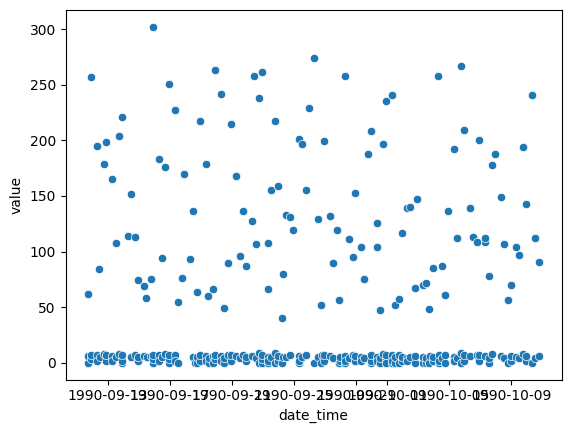

In [7]:
sns.scatterplot(data=df, x=df.date_time, y=df.value)

That's kind of neat. But we can do better.

Each of the points represents the value of a variable at a recorded time. Let's emphasize this using color: we can assign a color based on the type of measurement in the `interpretation` column.

While we're at it, let's make the dates and legend a little easier to read:

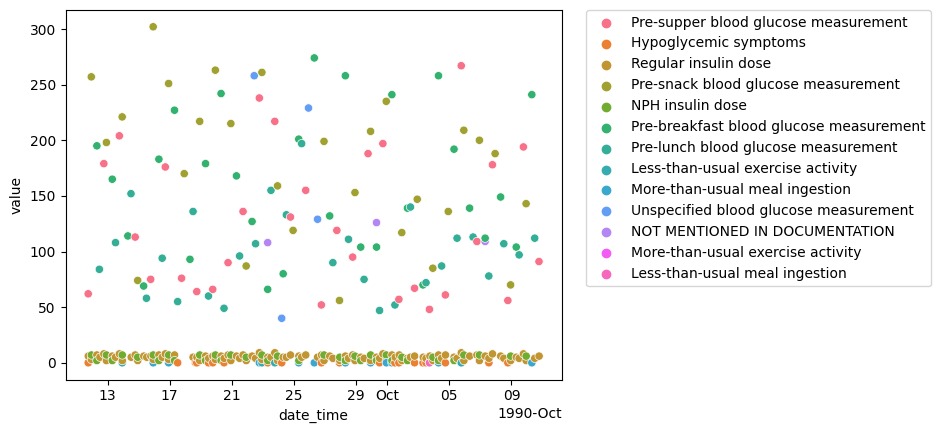

In [8]:
ax = sns.scatterplot(data=df, x=df.date_time, y=df.value, hue=df.interpretation)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Instead of trying to look at the mess that likely appears above, let's focus on places in time where the user reports experiencing hypoglycemia symptoms (where `code == 65`).

<div class="alert alert-block alert-warning">
<b>Warning:</b> It is possible that NO hypoglycemia cases were reported for a user, in which case the rest of this notebook will not make sense.

You can start down an alternate path by scrolling back up and trying a different user.
</div>

In [9]:
df[df.code == 65]

,date_time,code,value,interpretation
1,1990-09-11 18:01:00,65,0,Hypoglycemic symptoms
60,1990-09-17 12:15:00,65,0,Hypoglycemic symptoms
66,1990-09-18 15:44:00,65,0,Hypoglycemic symptoms
68,1990-09-18 17:48:00,65,0,Hypoglycemic symptoms
77,1990-09-19 11:53:00,65,0,Hypoglycemic symptoms
80,1990-09-19 18:28:00,65,0,Hypoglycemic symptoms
89,1990-09-20 11:52:00,65,0,Hypoglycemic symptoms
119,1990-09-23 07:22:00,65,0,Hypoglycemic symptoms
131,1990-09-24 05:01:00,65,0,Hypoglycemic symptoms
153,1990-09-26 18:17:00,65,0,Hypoglycemic symptoms


Let's focus in on the last entry.

Maybe the ten entries prior to hypoglycemic symptoms will help us understand this.

In [10]:
lh = df[df.code == 65].index[-1]
last = df.iloc[lh-10:lh+1].copy()

last

,date_time,code,value,interpretation
271,1990-10-07 13:06:00,65,0,Hypoglycemic symptoms
272,1990-10-07 13:07:00,33,4,Regular insulin dose
273,1990-10-07 18:36:00,62,178,Pre-supper blood glucose measurement
274,1990-10-07 18:38:00,33,8,Regular insulin dose
275,1990-10-07 22:42:00,64,188,Pre-snack blood glucose measurement
276,1990-10-08 07:13:00,58,149,Pre-breakfast blood glucose measurement
277,1990-10-08 07:16:00,33,6,Regular insulin dose
278,1990-10-08 12:08:00,60,107,Pre-lunch blood glucose measurement
279,1990-10-08 12:15:00,33,4,Regular insulin dose
280,1990-10-08 18:23:00,62,56,Pre-supper blood glucose measurement


And a visualization just of this portion:

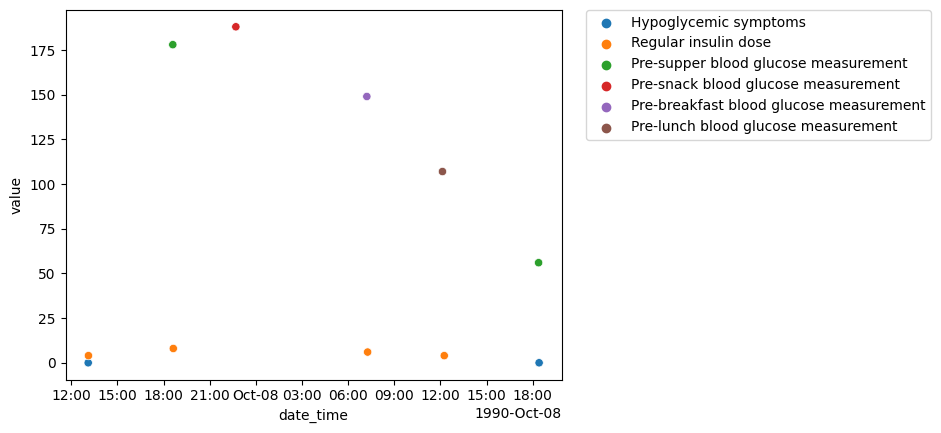

In [11]:
ax = sns.scatterplot(data=last, x=last.date_time, y=last.value, hue=last.interpretation)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

---

## Preliminary Modeling

We now have a sense of what our data looks like, how to visualize parts of it, and a question is forming in our head. Users can log their insulin doses, meal ingestion times, exercise windows, and when they experienced negative symptoms. Can we detect when hypoglycemia symptoms are about to occur?

Now comes the first key task in a modeling workflow: come up with *a* model.

It's like a rough draft&mdash;and many of our first drafts are bad.

Perhaps there is something informative about *which* events are logged?

In [12]:
df[df.code == 65]

,date_time,code,value,interpretation
1,1990-09-11 18:01:00,65,0,Hypoglycemic symptoms
60,1990-09-17 12:15:00,65,0,Hypoglycemic symptoms
66,1990-09-18 15:44:00,65,0,Hypoglycemic symptoms
68,1990-09-18 17:48:00,65,0,Hypoglycemic symptoms
77,1990-09-19 11:53:00,65,0,Hypoglycemic symptoms
80,1990-09-19 18:28:00,65,0,Hypoglycemic symptoms
89,1990-09-20 11:52:00,65,0,Hypoglycemic symptoms
119,1990-09-23 07:22:00,65,0,Hypoglycemic symptoms
131,1990-09-24 05:01:00,65,0,Hypoglycemic symptoms
153,1990-09-26 18:17:00,65,0,Hypoglycemic symptoms


We'll look at the seven events logged prior to when the hypoglycemia symptoms occurred, count which occurred and how many times, and try to use them to predict when symptoms occur.

This *might* have some plausibility. A trigger for low blood sugar may involve exercise and frequency of food habits, so we might expect some cases where exercise and meals interact to result in symptoms.

We will set this problem up in a few steps.

1. We want to count the number of codes prior to hypoglycemia symptoms (maybe the previous 7 records)
2. We want to keep track of *all* codes we encounter

So we can iterate over the indexes where symptoms occurred and record these in a list for later.

In [13]:
all_found = set()
positive_ex = []

for i in df[df.code == 65].index:
    codes = df.iloc[i-7:i].code.to_list()
    all_found.update(set(codes))
    positive_ex.append(Counter(codes))

We also need to be able to compare against cases where symptoms **did not** occur.

Maybe we can sample 25 random locations (without replacement) from the user's complete data, and repeat the procedure that we used in the positive cases.

In [14]:
from numpy.random import default_rng
rng = default_rng()

In [15]:
negatives = set(range(10, len(df))) - set(df[df.code == 65].index)
negative_indexes = rng.choice(list(negatives), size=25, replace=False)
negative_ex = []

for i in negative_indexes:
    codes = df.iloc[i-7:i].code.to_list()
    all_found.update(set(codes))
    negative_ex.append(Counter(codes))

This will give us some positive examples and 25 negative examples:

In [16]:
len(positive_ex), len(negative_ex)

(21, 25)

We've built up two lists of bag objects, and a set of all the codes recorded in each.

The final is to flatten the bags into vectors. This should result in a design matrix of $N$ values $\times~M$ features and a label vector of shape $N$.

In [17]:
y = []
X = []

for cnter in positive_ex:
    example = np.zeros(len(all_found))
    for i, v in enumerate(all_found):
        example[i] = cnter[v]
    X.append(example)
    y.append(1)

for cnter in negative_ex:
    example = np.zeros(len(all_found))
    for i, v in enumerate(all_found):
        example[i] = cnter[v]
    X.append(example)
    y.append(0)

X = np.asarray(X)
y = np.asarray(y)

(X.shape, y.shape)

((46, 12), (46,))

One more complication: we'll likely want to inspect the model we come up with. So let's fit a `DecisionTreeClassifier`.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

[Text(0.5, 0.8333333333333334, 'Count: Regular insulin dose <= 2.5\ngini = 0.498\nsamples = 34\nvalue = [18, 16]'),
 Text(0.25, 0.5, 'Count: Hypoglycemic symptoms <= 1.5\ngini = 0.454\nsamples = 23\nvalue = [8, 15]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.346\nsamples = 18\nvalue = [4, 14]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.75, 0.5, 'Count: NPH insulin dose <= 0.5\ngini = 0.165\nsamples = 11\nvalue = [10, 1]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]')]

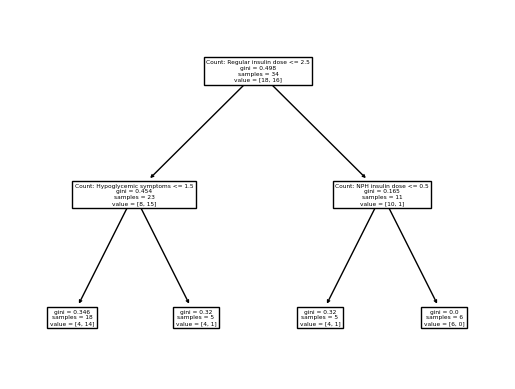

In [19]:
plot_tree(clf, feature_names=["Count: " + code_meanings[i] for i in all_found])

How did we do?

In [20]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.56      1.00      0.71         5

    accuracy                           0.67        12
   macro avg       0.78      0.71      0.66        12
weighted avg       0.81      0.67      0.65        12

